Generating simulated datasets...
✅ Saved simulated control data to 'data/raw/control_sample.csv'
✅ Saved simulated mtbi data to 'data/raw/mtbi_sample.csv'
Datasets generated successfully.
Processing Control Sample
Standard deviation: 0.0119
Result: No mTBI detected
------------------------------
Processing mTBI Sample
Standard deviation: 0.0211
Result: No mTBI detected
------------------------------


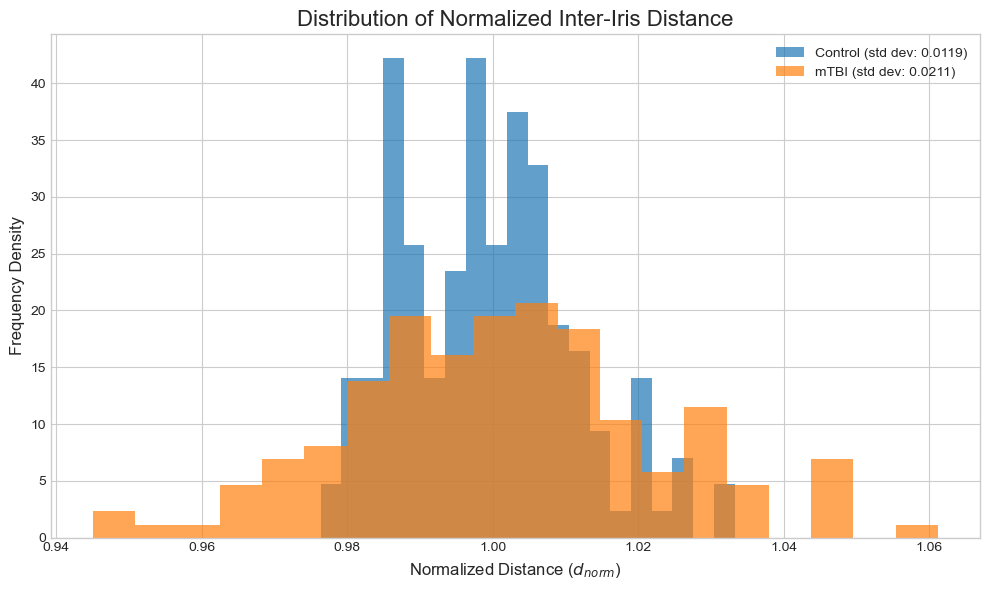

In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add the src/ folder to python's import path to access custom functions
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

from preprocess import generate_fake_landmark_data
from features import (
    compute_inter_iris_distance,
    compute_average_diameter,
    normalise_distance,
    compute_time_series_std,
    flag_mTBI
)

# Generate two sets of simulated data:
# - 'control': low noise
# - 'mtbi': high noise
print("Generating simulated datasets...")
generate_fake_landmark_data(num_rows=150, noise_level=0.1, label="control")
generate_fake_landmark_data(num_rows=150, noise_level=0.5, label="mtbi")
print("Datasets generated successfully.")


# Data Processing Function
# This function reads a data file, processes each row to calculate the normalised inter-iris distance (`d_norm`), and returns a list of these values. 

def process_dnorm(filepath):
    """
    Reads simulated eye-tracking data from a CSV file and computes the
    normalised inter-iris distance for each time step.

    Args:
        filepath (str): The path to the input CSV file.

    Returns:
        list: A list of floats representing the normalised inter-iris
              distance for each valid row in the file.
    """
    # Use a relative path to ensure the code works on any machine
    relative_path = os.path.join("..", filepath)
    try:
        df = pd.read_csv(relative_path)
    except FileNotFoundError:
        print(f"Error: File not found at {relative_path}")
        return []

    norm_distances = []
    for _, row in df.iterrows():
        try:
            # Extract landmark coordinates for clarity
            left_mid = (row["left_mid_x"], row["left_mid_y"])
            right_mid = (row["right_mid_x"], row["right_mid_y"])
            left_inner = (row["left_inner_x"], row["left_inner_y"])
            left_outer = (row["left_outer_x"], row["left_outer_y"])
            right_inner = (row["right_inner_x"], row["right_inner_y"])
            right_outer = (row["right_outer_x"], row["right_outer_y"])

            # Calculate the metrics
            inter_iris_dist = compute_inter_iris_distance(left_mid, right_mid)
            avg_diameter = compute_average_diameter(left_inner, left_outer, right_inner, right_outer)
            d_norm = normalise_distance(inter_iris_dist, avg_diameter)

            # Append the valid, calculated distance to our list
            if d_norm is not None and pd.notna(d_norm):
                norm_distances.append(d_norm)
        
        except KeyError as e:
            # Skip rows with missing data but inform the user
            print(f"Skipping row due to missing column: {e}")
            continue

    return norm_distances

# Analysis and Classification
# Both the control and mTBI samples are processed and classified.

print("Processing Control Sample")
control_norms = process_dnorm("data/raw/control_sample.csv")
control_std_dev = compute_time_series_std(control_norms)
is_mtbi_control = flag_mTBI(control_std_dev)

print(f"Standard deviation: {control_std_dev:.4f}")
print("Result: " + ("Likely mTBI" if is_mtbi_control else "No mTBI detected"))
print("-" * 30)

#Process mTBI Sample
print("Processing mTBI Sample")
mtbi_norms = process_dnorm("data/raw/mtbi_sample.csv")
mtbi_std_dev = compute_time_series_std(mtbi_norms)
is_mtbi_mtbi = flag_mTBI(mtbi_std_dev)

print(f"Standard deviation: {mtbi_std_dev:.4f}")
print("Result: " + ("Likely mTBI" if is_mtbi_mtbi else "No mTBI detected"))
print("-" * 30)


# Visualisation

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms with transparency
ax.hist(control_norms, bins=20, alpha=0.7, label=f'Control (std dev: {control_std_dev:.4f})', density=True)
ax.hist(mtbi_norms, bins=20, alpha=0.7, label=f'mTBI (std dev: {mtbi_std_dev:.4f})', density=True)

# Add titles and labels
ax.set_title('Distribution of Normalized Inter-Iris Distance', fontsize=16)
ax.set_xlabel('Normalized Distance ($d_{norm}$)', fontsize=12)
ax.set_ylabel('Frequency Density', fontsize=12)
ax.legend(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()
